# SageMaker DeepAR

<a href='https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html'>Amazon SageMaker DeepAR</a> is a supervised learning algorithm for forecasting scalar time series using recurrent neural networks (RNN). Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit one model to each individual time series, and then use that model to extrapolate the time series into the future. In many applications, however, you might have many similar time series across a set of cross-sectional units (for example, demand for different products, load of servers, requests for web pages, and so on). In this case, it can be beneficial to train a single model jointly over all of these time series. DeepAR takes this approach, training a model for predicting a time series over a large set of (related) time series.

Technical details can be found in this <a href='https://arxiv.org/pdf/1704.04110.pdf'>arXiv paper</a>.

In [1]:
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
matplotlib.rcParams['figure.figsize'] = (16, 9)
pd.options.display.max_columns = 999

## Load Dataset

In [3]:
df = pd.read_csv('../_datasets/san-francisco-traffic.csv', parse_dates=[0], index_col='DateTime')
print(df.shape)

(17544, 862)


In [4]:
# Only use first 100 columns
df = df.iloc[:, :100]
df.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,ts37,ts38,ts39,ts40,ts41,ts42,ts43,ts44,ts45,ts46,ts47,ts48,ts49,ts50,ts51,ts52,ts53,ts54,ts55,ts56,ts57,ts58,ts59,ts60,ts61,ts62,ts63,ts64,ts65,ts66,ts67,ts68,ts69,ts70,ts71,ts72,ts73,ts74,ts75,ts76,ts77,ts78,ts79,ts80,ts81,ts82,ts83,ts84,ts85,ts86,ts87,ts88,ts89,ts90,ts91,ts92,ts93,ts94,ts95,ts96,ts97,ts98,ts99,ts100
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,0.0144,0.0098,0.0157,0.0216,0.0345,0.0545,0.0061,0.0279,0.0200,0.0128,0.0186,0.0097,0.0154,0.0267,0.0441,0.0320,0.0195,0.0169,0.0565,0.0336,0.0200,0.0208,0.0341,0.0457,0.0177,0.0236,0.0082,0.0496,0.0441,0.0097,0.0197,0.0001,0.0321,0.0187,0.0181,0.0370,0.0403,0.0109,0.0281,0.0297,0.0279,0.0127,0.0249,0.0170,0.0308,0.0353,0.0147,0.0219,0.0322,0.0248,0.0275,0.0131,0.0060,0.0097,0.0166,0.0249,0.0340,0.0154,0.0153,0.0333,0.0207,0.0172,0.0156,0.0152,0.0108,0.0104,0.0245,0.0294,0.0193,0.0379,0.0158,0.0166,0.0169,0.0088,0.0226,0.0192,0.0253,0.0519,0.0153,0.0093,0.0330,0.0132,0.0128,0.0776,0.0064,0.0324,0.0099,0.0127,0.0178,0.0132
2015-01-01 01:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,0.0162,0.0114,0.0192,0.0239,0.0392,0.0870,0.0095,0.0279,0.0287,0.0134,0.0205,0.0073,0.0150,0.0338,0.0503,0.0424,0.0265,0.0183,0.0531,0.0397,0.0275,0.0265,0.0491,0.0502,0.0162,0.0258,0.0090,0.0573,0.0472,0.0073,0.0214,0.0000,0.0351,0.0211,0.0181,0.0354,0.0443,0.0118,0.0383,0.0341,0.0563,0.0160,0.0245,0.0302,0.0358,0.0478,0.0139,0.0208,0.0312,0.0292,0.0322,0.0164,0.0043,0.0073,0.0177,0.0290,0.0378,0.0191,0.0114,0.0319,0.0270,0.0230,0.0175,0.0158,0.0104,0.0148,0.0381,0.0361,0.0198,0.0510,0.0167,0.0217,0.0183,0.0111,0.0212,0.0275,0.0311,0.0651,0.0114,0.0097,0.0343,0.0173,0.0170,0.1000,0.0083,0.0365,0.0113,0.0142,0.0206,0.0175
2015-01-01 02:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,0.0122,0.0074,0.0137,0.0153,0.0233,0.0735,0.0068,0.0163,0.0225,0.0069,0.0142,0.0068,0.0102,0.0237,0.0374,0.0359,0.0180,0.0103,0.0402,0.0385,0.0188,0.0193,0.0348,0.0405,0.0132,0.0171,0.0055,0.0543,0.0413,0.0068,0.0164,0.0000,0.0279,0.0171,0.0136,0.0310,0.0416,0.0077,0.0284,0.0248,0.0393,0.0089,0.0145,0.0264,0.0297,0.0313,0.0098,0.0187,0.0214,0.0204,0.0200,0.0125,0.0034,0.0068,0.0090,0.0258,0.0302,0.0120,0.0100,0.0285,0.0207,0.0146,0.0147,0.0127,0.0120,0.0027,0.0300,0.0268,0.0190,0.0442,0.0147,0.0165,0.0126,0.0075,0.0153,0.0240,0.0197,0.0522,0.0100,0.0067,0.0235,0.0115,0.0105,0.0860,0.0050,0.0308,0.0073,0.0094,0.0106,0.0101
2015-01-01 03:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,0.0077,0.0060,0.0098,0.0082,0.0142,0.0424,0.0065,0.0083,0.0145,0.0042,0.0107,0.0070,0.0053,0.0172,0.0193,0.0224,0.0122,0.0060,0.0313,0.0329,0.0124,0.0144,0.0219,0.0349,0.0107,0.0108,0.0038,0.0330,0.0361,0.0070,0.0116,0.0000,0.0230,0.0171,0.0108,0.0253,0.0336,0.0061,0.0175,0.0149,0.0213,0.0056,0.0077,0.0142,0.0238,0.0215,0.0084,0.0155,0.0152,0.0110,0.0103,0.0078,0.0028,0.0070,0.0054,0.0191,0.0265,0.0079,0.0099,0.0259,0.0146,0.0075,0.0089,0.0154,0.0128,0.0003,0.0190,0.0135,0.0185,0.0199,0.0126,0.0152,0.0094,0.0050,0.0121,0.0136,0.0097,0.0401,0.0099,0.0054,0.0154,0.0061,0.0067,0.0552,0.0029,0.0216,0.0056,0.0045,0.0080,0.0062
2015-01-01 04:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,0.0055,0.0053,0.0088,0.0036,0.0101,0.0253,0.0059,0.0062,0.0086,0.0025,0.0089,0.0116,0.0032,0.0153,0.0104,0.0166,0.0117,0.0036,0.0277,0.0293,0.0092,0.0131,0.0159,0.0344,0.0090,0.0088,0.0031,0.0250,0.0318,0.0116,0.0098,0.0000,0.0196,0.0131,0.0094,0.0244,0.0293,0.0054,0.0126,0.0100,0.0112,0.0036,0.0057,0.0034,0.0214,0.0172,0.0075,0.0154,0.0103,0.0074,0.0062,0.0062,0.0037,0.0116,0.0038,0.0162,0.0254,0.0061,0.0129,0.0230,0.0099,0

## Define Parameters

Make predictions for 24-hour period based on the previous four weeks' worth of data. DeepAR will be trained across the whole dataset (excluding the 24-hour test period).

In [5]:
dataset_name = 'San Francisco Traffic'
dataset_abbr = 'SFT'
model_name = 'DeepAR'
context_length = 24*7*4 # Four weeks
prediction_length = 24
freq = pd.infer_freq(df.index)

## Configure S3 Storage and Container

In [6]:
bucket = '<your_bucket_name_here>'
prefix = 'sagemaker/deepar/%s' % dataset_abbr

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, the container image is configured to be use the appropriate region.

In [7]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-1': '633353088612.dkr.ecr.ap-northeast-1.amazonaws.com/forecasting-deepar:latest',
    'ap-northeast-2': '204372634319.dkr.ecr.ap-northeast-2.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

## Define Error Metric

The seasonal variant of the mean absolute scaled error (MASE) will be used to evaluate the forecasts.

In [8]:
def calc_sMASE(training_series, testing_series, prediction_series, seasonality=prediction_length):
    a = training_series.iloc[seasonality:].values
    b = training_series.iloc[:-seasonality].values
    d = np.sum(np.abs(a-b)) / len(a)
    errors = np.abs(testing_series - prediction_series)
    return np.mean(errors) / d

## Prepare Data for SageMaker

Extract time series and set aside data for testing.

In [9]:
time_series = []
for k in df.columns:
    time_series.append(df[k])
    
time_series_training = []
for ts in df.columns:
    time_series_training.append(df.iloc[:-prediction_length][ts])

Visualise time series example.

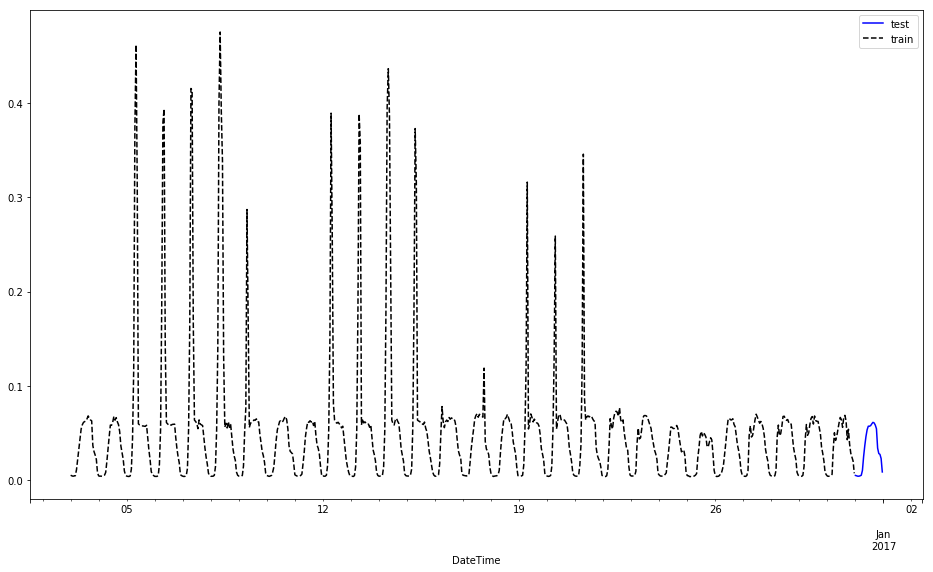

In [10]:
time_series[0][-prediction_length:].plot(label='test', figsize=(16, 9), c='b')
time_series_training[0][-context_length:].plot(label='train', c='k', linestyle='--')
plt.legend()
plt.show()

Convert time series into JSON strings for DeepAR.

In [11]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [12]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

## Train Model

Define the estimator for training and set hyperparameters.

In [13]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p3.8xlarge',
    base_job_name='%s-deepar' % dataset_abbr,
    output_path="s3://" + s3_output_path
)

In [14]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [15]:
estimator.set_hyperparameters(**hyperparameters)

Launch training job.

In [16]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: SFT-deepar-2019-03-08-18-57-35-207


2019-03-08 18:57:35 Starting - Starting the training job...
2019-03-08 18:57:36 Starting - Launching requested ML instances......
2019-03-08 18:58:36 Starting - Preparing the instances for training...
2019-03-08 18:59:32 Downloading - Downloading input data...
2019-03-08 18:59:40 Training - Downloading the training image..
Arguments: train
[03/08/2019 19:00:16 INFO 140082988787520] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[03/08/2019 19:00:16 INFO 14008

[03/08/2019 19:07:12 INFO 140082988787520] Epoch[2] Batch[5] avg_epoch_loss=-2.245331
[03/08/2019 19:07:12 INFO 140082988787520] Epoch[2] Batch [5]#011Speed: 21.69 samples/sec#011loss=-2.245331
[03/08/2019 19:07:17 INFO 140082988787520] processed a total of 277 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 14180.513143539429, "sum": 14180.513143539429, "min": 14180.513143539429}}, "EndTime": 1552072037.300852, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552072023.120288}

[03/08/2019 19:07:17 INFO 140082988787520] #throughput_metric: host=algo-1, train throughput=19.5337207397 records/second
[03/08/2019 19:07:17 INFO 140082988787520] #progress_metric: host=algo-1, completed 15 % of epochs
[03/08/2019 19:07:17 INFO 140082988787520] best epoch loss so far
[03/08/2019 19:07:17 INFO 140082988787520] Saved checkpoint to "/opt/ml/model/state_194d4daf-15f7-44da-8265-2dd390af74a9-0000.params"
#metrics {"Metrics": {"sta

[03/08/2019 19:08:49 INFO 140082988787520] processed a total of 305 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 15729.663848876953, "sum": 15729.663848876953, "min": 15729.663848876953}}, "EndTime": 1552072129.930698, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552072114.20098}

[03/08/2019 19:08:49 INFO 140082988787520] #throughput_metric: host=algo-1, train throughput=19.3899824397 records/second
[03/08/2019 19:08:49 INFO 140082988787520] #progress_metric: host=algo-1, completed 45 % of epochs
[03/08/2019 19:08:49 INFO 140082988787520] best epoch loss so far
[03/08/2019 19:08:50 INFO 140082988787520] Saved checkpoint to "/opt/ml/model/state_05456bf7-d662-4d45-a0e2-3a31d6acca23-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 278.3548831939697, "sum": 278.3548831939697, "min": 278.3548831939697}}, "EndTime": 1552072130.209552, "Dimensions": {"Host": "algo-1", "Operation": "train

[03/08/2019 19:10:38 INFO 140082988787520] Epoch[15] Batch[5] avg_epoch_loss=-3.028264
[03/08/2019 19:10:38 INFO 140082988787520] Epoch[15] Batch [5]#011Speed: 21.65 samples/sec#011loss=-3.028264
[03/08/2019 19:10:44 INFO 140082988787520] processed a total of 289 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 15744.64201927185, "sum": 15744.64201927185, "min": 15744.64201927185}}, "EndTime": 1552072244.093227, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1552072228.348514}

[03/08/2019 19:10:44 INFO 140082988787520] #throughput_metric: host=algo-1, train throughput=18.3553222626 records/second
[03/08/2019 19:10:44 INFO 140082988787520] #progress_metric: host=algo-1, completed 80 % of epochs
[03/08/2019 19:10:44 INFO 140082988787520] best epoch loss so far
[03/08/2019 19:10:44 INFO 140082988787520] Saved checkpoint to "/opt/ml/model/state_3595fdfd-cf76-4a7a-a0af-b6ba2892a9fc-0000.params"
#metrics {"Metrics": {"stat


2019-03-08 19:25:23 Uploading - Uploading generated training model
2019-03-08 19:25:35 Completed - Training job completed
Billable seconds: 1563


## Create Endpoint and Predictor

In [17]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: SFT-deepar-2019-03-08-18-57-35-207
INFO:sagemaker:Creating endpoint-config with name SFT-deepar-2019-03-08-18-57-35-207
INFO:sagemaker:Creating endpoint with name SFT-deepar-2019-03-08-18-57-35-207


---------------------------------------------------------------------------------------!

Create utility class to make predictions from Pandas Series.

In [18]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [(x.index[-1].to_period(self.freq)+1).to_timestamp() for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [19]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make Predictions

In [20]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series

In [21]:
tic = time.time()
for i in range(5, len(time_series), 5):
    toc = time.time()
    print("Running predictions for time series {} to {}... (cumulative time: {:.1f}s.)".format(
        i+1, min(i+5, len(time_series))+1, toc-tic))
    pred = predictor.predict(time_series_training[i:(i+5)])
    list_of_df = list_of_df + pred

Running predictions for time series 6 to 11... (cumulative time: 0.0s.)
Running predictions for time series 11 to 16... (cumulative time: 1.7s.)
Running predictions for time series 16 to 21... (cumulative time: 3.1s.)
Running predictions for time series 21 to 26... (cumulative time: 4.5s.)
Running predictions for time series 26 to 31... (cumulative time: 6.1s.)
Running predictions for time series 31 to 36... (cumulative time: 7.6s.)
Running predictions for time series 36 to 41... (cumulative time: 9.0s.)
Running predictions for time series 41 to 46... (cumulative time: 10.4s.)
Running predictions for time series 46 to 51... (cumulative time: 11.8s.)
Running predictions for time series 51 to 56... (cumulative time: 13.2s.)
Running predictions for time series 56 to 61... (cumulative time: 14.6s.)
Running predictions for time series 61 to 66... (cumulative time: 16.3s.)
Running predictions for time series 66 to 71... (cumulative time: 17.7s.)
Running predictions for time series 71 to 76..

Show some example forecasts.

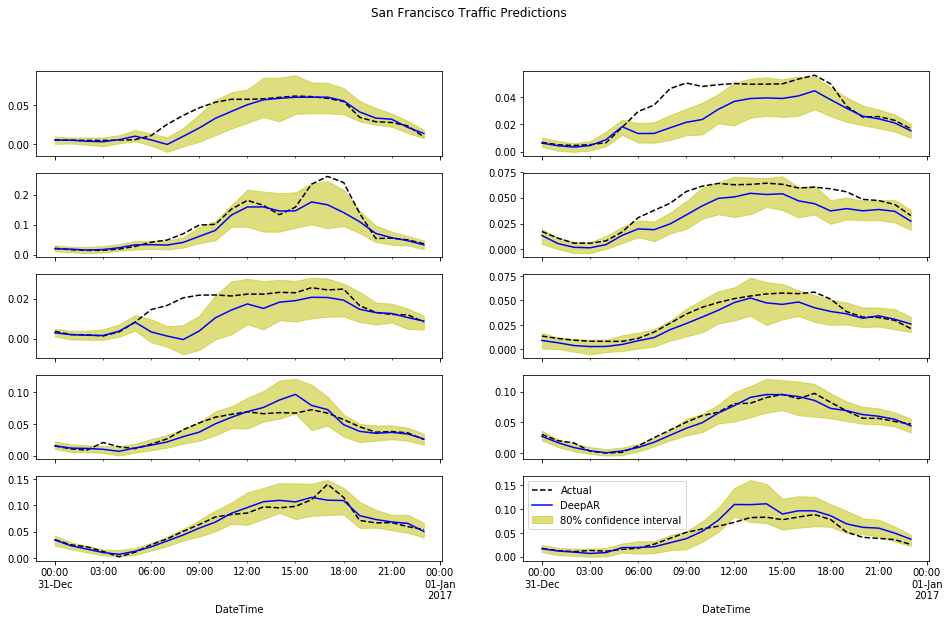

In [22]:
fig, ax = plt.subplots(5, 2, sharex=True)
ax = ax.ravel()

for k in range(10):
    actual_data[k][-prediction_length:].plot(label='Actual', c='k',
                                             linestyle='--', ax=ax[k])
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    ax[k].fill_between(p10.index, p10, p90, color='y', alpha=0.5,
                         label='80% confidence interval')
    list_of_df[k]['0.5'][-prediction_length:].plot(label='DeepAR', c='b', ax=ax[k])
ax[9].legend()
fig.suptitle('{} Predictions'.format(dataset_name))
plt.show()

## Evaluate DeepAR

In [23]:
results = df.copy()
for i in range(len(results.columns)):
    results['pred%s' % (i+1)] = 0
    results['pred%s' % (i+1)].iloc[-prediction_length:] = list_of_df[i]['0.5'].values

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Power must be positive, so setting any negative values equal to zero will improve the accuracy of the model.

In [24]:
results0 = results.copy()
results0[results0 < 0] = 0
results0.head()

,ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9,ts10,ts11,ts12,ts13,ts14,ts15,ts16,ts17,ts18,ts19,ts20,ts21,ts22,ts23,ts24,ts25,ts26,ts27,ts28,ts29,ts30,ts31,ts32,ts33,ts34,ts35,ts36,ts37,ts38,ts39,ts40,ts41,ts42,ts43,ts44,ts45,ts46,ts47,ts48,ts49,ts50,ts51,ts52,ts53,ts54,ts55,ts56,ts57,ts58,ts59,ts60,ts61,ts62,ts63,ts64,ts65,ts66,ts67,ts68,ts69,ts70,ts71,ts72,ts73,ts74,ts75,ts76,ts77,ts78,ts79,ts80,ts81,ts82,ts83,ts84,ts85,ts86,ts87,ts88,ts89,ts90,ts91,ts92,ts93,ts94,ts95,ts96,ts97,ts98,ts99,ts100,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred25,pred26,pred27,pred28,pred29,pred30,pred31,pred32,pred33,pred34,pred35,pred36,pred37,pred38,pred39,pred40,pred41,pred42,pred43,pred44,pred45,pred46,pred47,pred48,pred49,pred50,pred51,pred52,pred53,pred54,pred55,pred56,pred57,pred58,pred59,pred60,pred61,pred62,pred63,pred64,pred65,pred66,pred67,pred68,pred69,pred70,pred71,pred72,pred73,pred74,pred75,pred76,pred77,pred78,pred79,pred80,pred81,pred82,pred83,pred84,pred85,pred86,pred87,pred88,pred89,pred90,pred91,pred92,pred93,pred94,pred95,pred96,pred97,pred98,pred99,pred100
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,0.0144,0.0098,0.0157,0.0216,0.0345,0.0545,0.0061,0.0279,0.0200,0.0128,0.0186,0.0097,0.0154,0.0267,0.0441,0.0320,0.0195,0.0169,0.0565,0.0336,0.0200,0.0208,0.0341,0.0457,0.0177,0.0236,0.0082,0.0496,0.0441,0.0097,0.0197,0.0001,0.0321,0.0187,0.0181,0.0370,0.0403,0.0109,0.0281,0.0297,0.0279,0.0127,0.0249,0.0170,0.0308,0.0353,0.0147,0.0219,0.0322,0.0248,0.0275,0.0131,0.0060,0.0097,0.0166,0.0249,0.0340,0.0154,0.0153,0.0333,0.0207,0.0172,0.0156,0.0152,0.0108,0.0104,0.0245,0.0294,0.0193,0.0379,0.0158,0.0166,0.0169,0.0088,0.0226,0.0192,0.0253,0.0519,0.0153,0.0093,0.0330,0.0132,0.0128,0.0776,0.0064,0.0324,0.0099,0.0127,0.0178,0.0132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,0.0162,0.0114,0.0192,0.0239,0.0392,0.0870,0.0095,0.0279,0.0287,0.0134,0.0205,0.0073,0.0150,0.0338,0.0503,0.0424,0.0265,0.0183,0.0531,0.0397,0.0275,0.0265,0.0491,0.0502,0.0162,0.0258,0.0090,0.0573,0.0472,0.0073,0.0214,0.0000,0.0351,0.0211,0.0181,0.0354,0.0443,0.0118,0.0383,0.0341,0.0563,0.0160,0.0245,0.0302,0.0358,0.0478,0.0139,0.0208,0.0312,0.0292,0.0322,0.0164,0.0043,0.0073,0.0177,0.0290,0.0378,0.0191,0.0114,0.0319,0.0270,0.0230,0.0175,0.0158,0.0104,0.0148,0.0381,0.0361,0.0198,0.0510,0.0167,0.0217,0.0183,0.0111,0.0212,0.0275,0.0311,0.0651,0.0114,0.0097,0.0343,0.0173,0.0170,0.1000,0.0083,0.0365,0.0113,0.0142,0.0206,0.0175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,0.0122,0.0074,0.0137,0.0153,0.0233,0.0735,0.0068,0.0163,0.0225,0.0069,0.0142,0.0068,0.0102,0.0237,0.0374,0.0359,0.0180,0.0103,0.0402,0.0385,0.0188,0.0193,0.0348,0.0405,0.0132,0.0171,0.0055,0.0543,0.0413,0.0068,0.0164,0.0000,0.0279,0.0171,0.0136,0.0310,0.0416,0.0077,0.0284,0.0

In [25]:
sMASEs = []
for i, col in enumerate(df.columns):
    sMASEs.append(calc_sMASE(results0[col].iloc[-(context_length+prediction_length):-prediction_length],
                             results0[col].iloc[-prediction_length:],
                             results0['pred%s' % str(i+1)].iloc[-prediction_length:]))

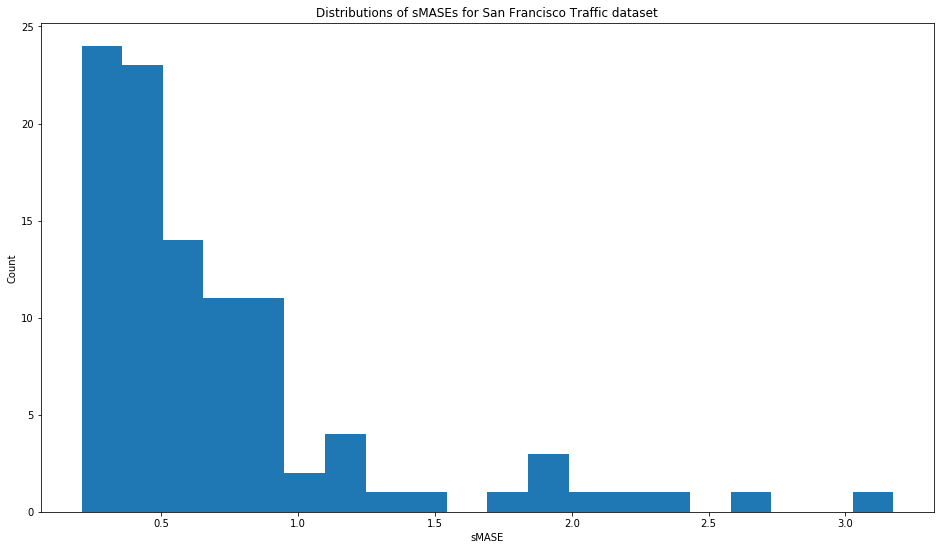

In [26]:
fig, ax = plt.subplots()
ax.hist(sMASEs, bins=20)
ax.set_title('Distributions of sMASEs for {} dataset'.format(dataset_name))
ax.set_xlabel('sMASE')
ax.set_ylabel('Count');

In [27]:
sMASE = np.mean(sMASEs)
print("Overall sMASE: {:.4f}".format(sMASE))

Overall sMASE: 0.7178


Store the predictions and accuracy score for the DeepAR model.

In [28]:
import pickle
    
with open('{}-sMASE.pkl'.format(dataset_abbr), 'wb') as f:
    pickle.dump(sMASE, f)
    
with open('../_results/{}/{}-results.pkl'.format(model_name, dataset_abbr), 'wb') as f:
    pickle.dump(results.iloc[-prediction_length:], f)

## Delete Endpoint

In [29]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: SFT-deepar-2019-03-08-18-57-35-207
